In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from seysmo.models.model_class import ParallelLSTMConv1DModel
from seysmo.models.train_model import train, evaluate
from seysmo.models.utils import save_model, load_model, count_parameters
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import MeanAbsolutePercentageError
from torchvision.transforms import ToTensor

import mlflow

In [2]:
data = pd.read_csv("../data/processed/max_inputs.csv", index_col=0)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,213.00600,205.439,289.82788,358.09497,403.11597,537.03100,611.37180,591.17600,529.47000,391.32886
1,222.75400,220.226,257.12085,333.08180,407.12280,525.98900,554.07300,576.30884,517.71290,384.71387
2,279.99097,238.884,163.95900,207.80600,297.75488,367.54492,416.18090,444.21290,461.24683,470.62378
3,223.49500,216.976,212.86200,233.52200,265.25195,296.36694,318.65698,331.29883,338.37890,342.09595
4,248.75500,217.254,185.82700,210.49100,272.65480,366.32983,370.02588,422.46387,449.37500,453.95288


In [3]:
output = pd.read_csv("../data/processed/max_outputs.csv", index_col=0)
output.head()

,0,1,2,3,4,5,6,7,8,9
0,222.970,194.994,347.695,266.658,456.961,609.606,686.317,656.043,538.476,385.552
1,213.461,225.044,249.679,344.489,432.059,497.771,517.216,520.011,491.669,444.445
2,290.881,237.973,159.295,214.495,304.404,360.967,399.726,418.742,418.672,415.697
3,247.240,224.699,195.406,234.057,252.405,345.537,360.561,335.349,292.247,253.319
4,254.710,224.038,178.900,209.792,285.527,349.023,396.075,414.229,425.102,428.175


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, output, test_size=0.10, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=1) # 0.25 x 0.8 = 0.2

In [5]:
print("Shape of train: ", y_train.shape)
print("Shape of test: ", y_test.shape)
print("Shape of validatation: ", y_val.shape)

Shape of train:  (3490, 10)
Shape of test:  (437, 10)
Shape of validatation:  (437, 10)


In [6]:
mlflow.set_tracking_uri("http://localhost:5000")

In [7]:
mlflow.set_experiment("/first_try")

<Experiment: artifact_location='mlflow-artifacts:/550861899779064546', creation_time=1720864125065, experiment_id='550861899779064546', last_update_time=1720864125065, lifecycle_stage='active', name='/first_try', tags={}>

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_input_size = 1
lstm_hidden_size = 64
conv_in_channels = 1
conv_out_channels = 32
conv_kernel_size = 3
pool_kernel_size = 2
sequence_length = 10
fc1_output_size = 64
fc2_output_size = 10
epochs = 100
b_size = 32
lr = 0.001
loss_fn = nn.MSELoss()
metric_fn = MeanAbsolutePercentageError().to(device)
model = ParallelLSTMConv1DModel(lstm_input_size=lstm_input_size, lstm_hidden_size=lstm_hidden_size, conv_in_channels=conv_in_channels, conv_out_channels=conv_out_channels, conv_kernel_size=conv_kernel_size, pool_kernel_size=pool_kernel_size, sequence_length=sequence_length, fc1_output_size=fc1_output_size, fc2_output_size=fc2_output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

class SignalSpeedDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SignalSpeedDataset(X_train.to_numpy(dtype=np.float32).reshape((3490, 10, 1)), y_train.to_numpy(dtype=np.float32))
train_dataloader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
val_dataset = SignalSpeedDataset(X_val.to_numpy(dtype=np.float32).reshape((437, 10, 1)), y_val.to_numpy(dtype=np.float32))
val_dataloader = DataLoader(val_dataset, batch_size=b_size, shuffle=True)
test_dataset = SignalSpeedDataset(X_test.to_numpy(dtype=np.float32).reshape((437, 10, 1)), y_test.to_numpy(dtype=np.float32))
test_dataloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True)

In [10]:
with mlflow.start_run() as run:
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "batch_size": b_size,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": "ADAM",
        "lstm_input_size": lstm_input_size,
        "lstm_hidden_size": lstm_hidden_size,
        "conv_in_channels": conv_in_channels,
        "conv_out_channels": conv_out_channels,
        "conv_kernel_size": conv_kernel_size,
        "pool_kernel_size": pool_kernel_size,
        "sequence_length": sequence_length,
        "fc1_output_size": fc1_output_size,
        "fc2_output_size": fc2_output_size,
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("../models/model_P_summary.txt", "w", encoding="utf-8") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("../models/model_P_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, metric_fn, optimizer, epoch=t, device=device)
        evaluate(val_dataloader, model, loss_fn, metric_fn, epoch=t, device=device)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

Epoch 1
-------------------------------
loss: 119228.773438 MAPE: 1.021529 [0 / 110]
loss: 1336.119263 MAPE: 0.102274 [100 / 110]
Eval metrics: 
MAPE: 0.10, Avg loss: 1462.707005 

Epoch 2
-------------------------------
loss: 1859.527344 MAPE: 0.116600 [0 / 110]
loss: 904.465820 MAPE: 0.080056 [100 / 110]
Eval metrics: 
MAPE: 0.08, Avg loss: 1132.149506 

Epoch 3
-------------------------------
loss: 1976.931274 MAPE: 0.108890 [0 / 110]
loss: 645.342590 MAPE: 0.063800 [100 / 110]
Eval metrics: 
MAPE: 0.07, Avg loss: 758.921077 

Epoch 4
-------------------------------
loss: 769.711914 MAPE: 0.063687 [0 / 110]
loss: 740.970886 MAPE: 0.058413 [100 / 110]
Eval metrics: 
MAPE: 0.05, Avg loss: 563.815822 

Epoch 5
-------------------------------
loss: 491.632050 MAPE: 0.047793 [0 / 110]
loss: 354.040344 MAPE: 0.042099 [100 / 110]
Eval metrics: 
MAPE: 0.04, Avg loss: 456.004961 

Epoch 6
-------------------------------
loss: 536.524841 MAPE: 0.043770 [0 / 110]
loss: 416.217865 MAPE: 0.03825

2024/07/14 16:35:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


loss: 417.226624 MAPE: 0.024650 [100 / 110]
Eval metrics: 
MAPE: 0.02, Avg loss: 272.702200 


2024/07/14 16:35:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [12]:
num_batches = len(test_dataloader)
eval_loss, eval_mape = 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        eval_loss += loss_fn(torch.reshape(pred, (-1, 10)), y).item()
        eval_mape += metric_fn(torch.reshape(pred, (-1, 10)), y).item()

eval_loss /= num_batches
eval_mape /= num_batches
print(f"Test loss: {eval_loss:4f}")
print(f"Test MAPE: {eval_mape:4f}")

Test loss: 306.281368
Test MAPE: 0.024227


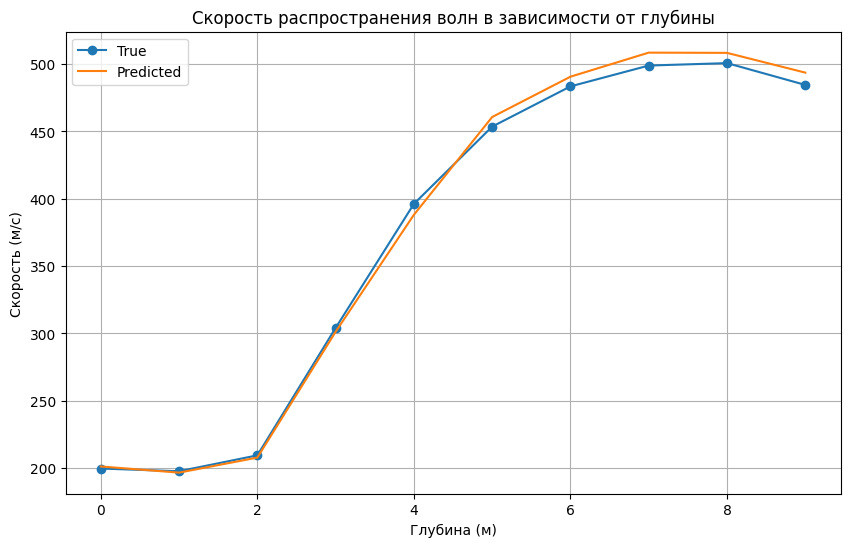

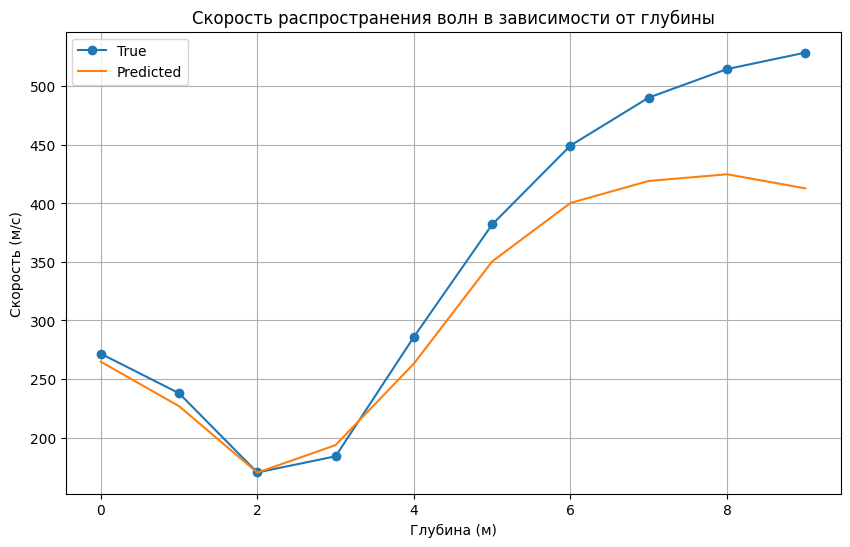

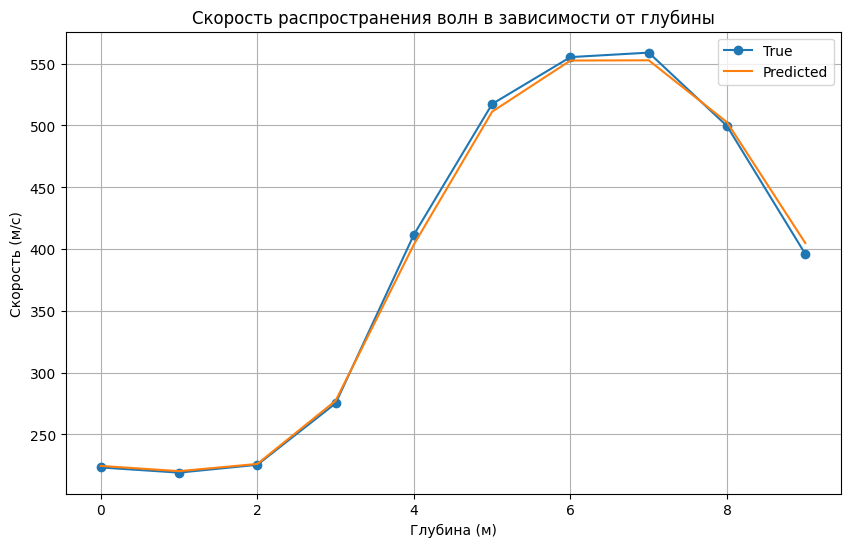

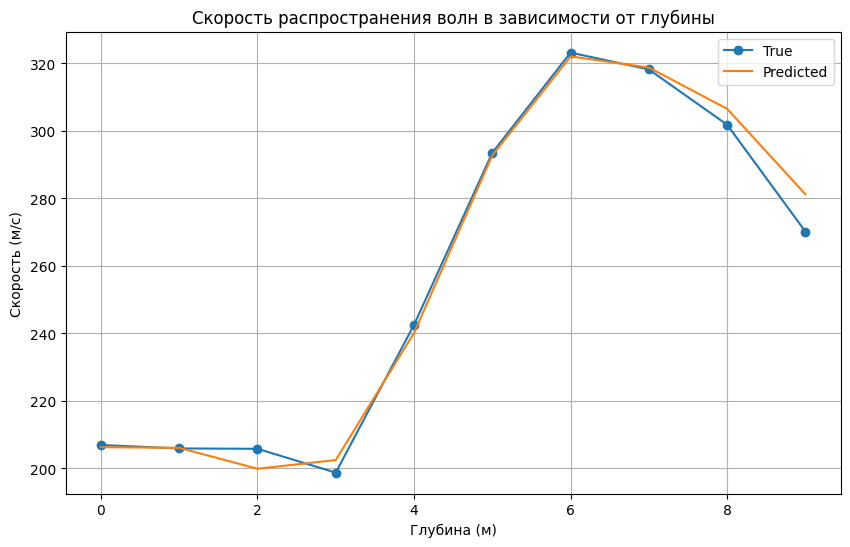

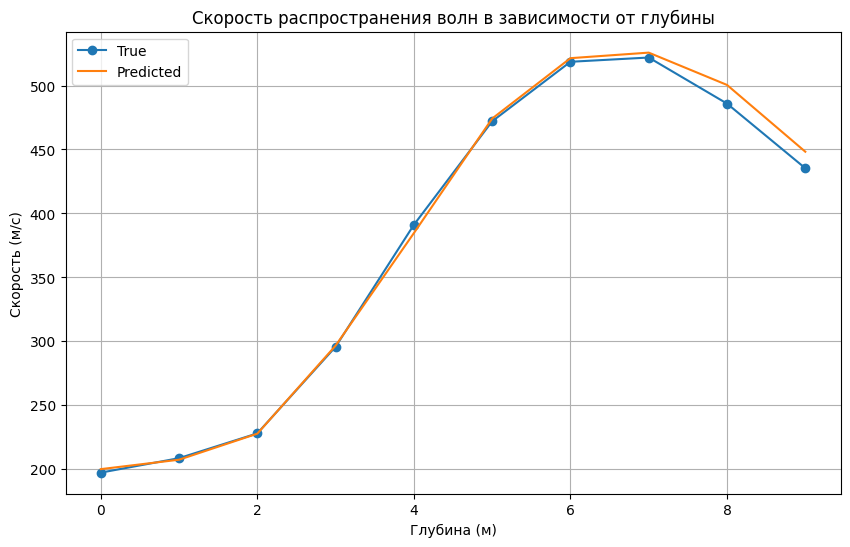

In [16]:
for i in range(5):
    a = model(torch.tensor(X_val.iloc[i].to_numpy().reshape((1,10,1))).to(device)).cpu().detach().numpy()
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(10), y_val.iloc[i], marker='o', label='True')
    plt.plot(np.arange(10), a.flatten(), label='Predicted')
    plt.xlabel('Глубина (м)')
    plt.ylabel('Скорость (м/с)')
    plt.title('Скорость распространения волн в зависимости от глубины')
    plt.grid(True)
    plt.legend()
    plt.show()

In [17]:
torch.save(model.state_dict(), "../models/Parallel_arch.pt")

In [24]:
count_parameters(model)

30282

In [ ]:
# В презентации поговорить о количестве данных